In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics
import seaborn as sns
from scipy.stats import poisson
from data_loading import *
import pickle
from patsy import dmatrices
import statsmodels.api as sm

In [86]:
df = load_final_dataframe()
df_nonzero = df.loc[df.precinct.isin(df.precinct.unique()[df.groupby(['precinct']).sum().bike_count > 1])]

D:\tubingen\Sem1\Data Literacy\Project\city-biking\data_loading.py:114: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ksi = ksi.groupby(['precinct', 'year']).sum()


In [223]:
def train_test_set_year(df):
    mask = np.ones(len(df), dtype=bool)
    mask[5::6] = False

    df_train = df[mask]
    df_test = df[~mask]
    print('Training data set length='+str(len(df_train)))
    print('Testing data set length='+str(len(df_test)))
    expr = """injuries ~ year + precinct + crashes+ bike_count"""
    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
    X_train = X_train.drop(columns=['Intercept'])
    X_test = X_test.drop(columns=['Intercept'])
    return X_train, y_train, X_test, y_test

In [256]:
def poisson_train_predict(X_train, y_train, X_test, print_summary = True):
    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    poisson_predictions = poisson_training_results.get_prediction(X_test)
    predictions_summary_frame = poisson_predictions.summary_frame()
    if print_summary:
        print(poisson_training_results.summary())
        print(predictions_summary_frame)
    return predictions_summary_frame
    
def pred_analysis(predictions_summary_frame, y_test):
    predicted_counts=predictions_summary_frame['mean']
    actual_counts = y_test['injuries']
    fig = plt.figure()
    fig.suptitle('Predicted versus actual injuries')
    predicted, = plt.plot(X_test.precinct, predicted_counts, 'go-', label='Predicted injuries')
    actual, = plt.plot(X_test.precinct, actual_counts, 'ro-', label='Actual injuries')
    plt.legend(handles=[predicted, actual])
    plt.show()
    rms = np.sqrt(mean_squared_error(y_test['injuries'], predicted_counts))
    return rms

def train_pred_individual(X_train, y_train, X_test,y_test):
    preds = []
    for i in range(1,len(y_test)+1):
        poisson_training_results = sm.GLM(y_train[0:i*5], X_train[0:i*5], family=sm.families.Poisson()).fit()

        poisson_predictions = poisson_training_results.get_prediction(X_test[i-1:i])

        predictions_summary_frame = poisson_predictions.summary_frame()['mean']
        preds.append(predictions_summary_frame)
    predicted_counts=preds
    actual_counts = y_test['injuries']
    fig = plt.figure()
    fig.suptitle('Predicted versus actual injuries')
    predicted, = plt.plot(X_test.precinct, predicted_counts, 'go-', label='Predicted injuries')
    actual, = plt.plot(X_test.precinct, actual_counts, 'ro-', label='Actual injuries')
    plt.legend(handles=[predicted, actual])
    plt.show()
    rms = np.sqrt(mean_squared_error(y_test['injuries'], predicted_counts))
    preds_df = pd.concat(preds)
    diff_df = (np.abs(preds_df - y_test['injuries']))
    y_test['predictions'] = preds_df
    y_test['diff']  = diff_df
    return y_test,rms

Training data set length=385
Testing data set length=77
                 Generalized Linear Model Regression Results                  
Dep. Variable:               injuries   No. Observations:                  385
Model:                            GLM   Df Residuals:                      381
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1757.1
Date:                Fri, 27 Jan 2023   Deviance:                       1293.9
Time:                        20:39:16   Pearson chi2:                 1.18e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

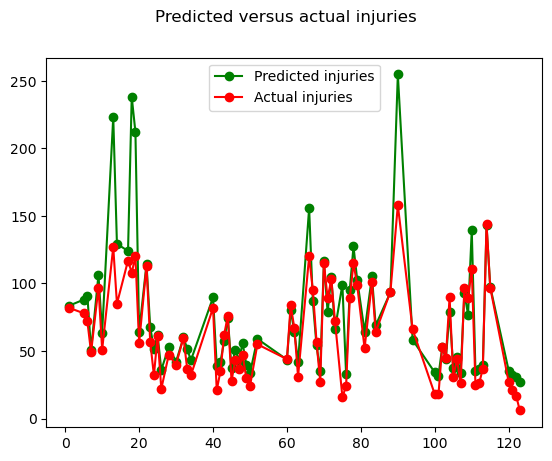

28.079297778078537

In [249]:
#Whole dataset
X_train, y_train, X_test, y_test = train_test_set_year(df)
predictions_summary_frame = poisson_train_predict(X_train, y_train, X_test)
rms = pred_analysis(predictions_summary_frame, y_test)
rms

Training data set length=205
Testing data set length=41
                 Generalized Linear Model Regression Results                  
Dep. Variable:               injuries   No. Observations:                  205
Model:                            GLM   Df Residuals:                      201
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -878.27
Date:                Fri, 27 Jan 2023   Deviance:                       521.24
Time:                        20:39:27   Pearson chi2:                     494.
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

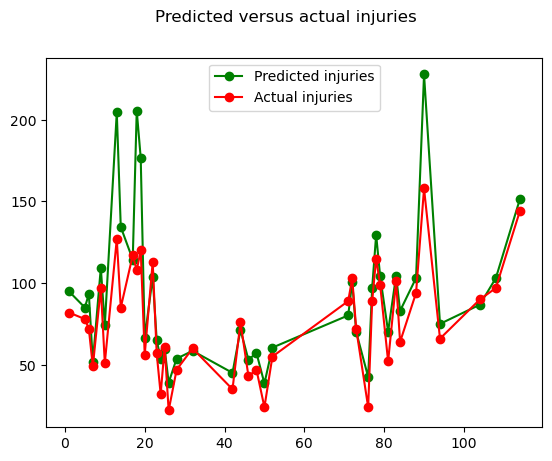

27.408213454764674

In [250]:
#NONZERO ALL
X_train, y_train, X_test, y_test = train_test_set_year(df_nonzero)
predictions_summary_frame = poisson_train_predict(X_train, y_train, X_test)
rms = pred_analysis(predictions_summary_frame, y_test)
rms

Training data set length=205
Testing data set length=41


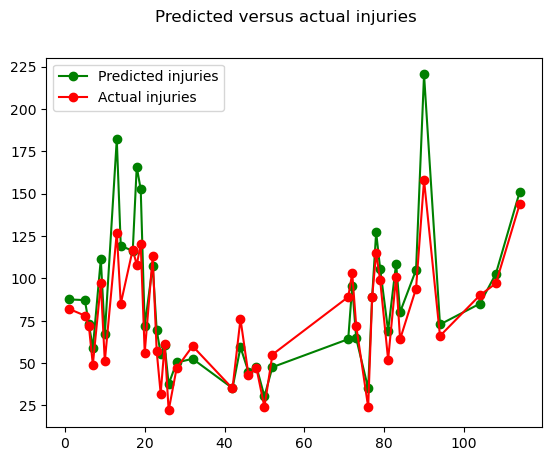

20.231389152407974

In [257]:
#NONZERO EACH CASE
X_train, y_train, X_test, y_test = train_test_set_year(df_nonzero)
pred_df, rms = train_pred_individual(X_train, y_train, X_test,y_test)
rms